Method and Results:

In [28]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(ggplot2)
options(repr.matrix.max.rows = 6)
source('cleanup.R')

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'cleanup.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [3]:
set.seed(1000)  

players <- read_csv("https://raw.githubusercontent.com/AnaSri-DSCI/dsci-100-2025-group-005-18/refs/heads/main/players.csv")
players

players_select <- players |>
    select(experience, played_hours, Age)
    
   
players_split <- initial_split(players_select, prop = 0.75, strata = played_hours)
players_training <- training(players_split)
players_training
players_testing <- testing(players_split)
players_testing

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


experience,played_hours,Age
<chr>,<dbl>,<dbl>
Veteran,0.0,17
Regular,0.1,21
Amateur,0.0,17
⋮,⋮,⋮
Amateur,0.8,22
Amateur,32.0,22
Amateur,2.3,17


experience,played_hours,Age
<chr>,<dbl>,<dbl>
Regular,0.0,19
Amateur,0.0,21
Veteran,1.6,23
⋮,⋮,⋮
Pro,1.7,17
Amateur,0.0,17
Pro,0.2,NA


In this first step, we are first loading the dataset "players.csv" from the github repository, and selecting the columns needed to answer our question. Using the select() function, the columns experience, age, and played_hours are selected as experience and age are our predictors to find the number of played_hours. Finally, we split the data set, and create training and testing dataframes to use for the knn regression analysis. The training() function is a split of the original code that is used to test the knn regression on the dataset, whereas, the testing() function evaluates the performance of the model by comparing predicted values to actual values.

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_smooth()`).”


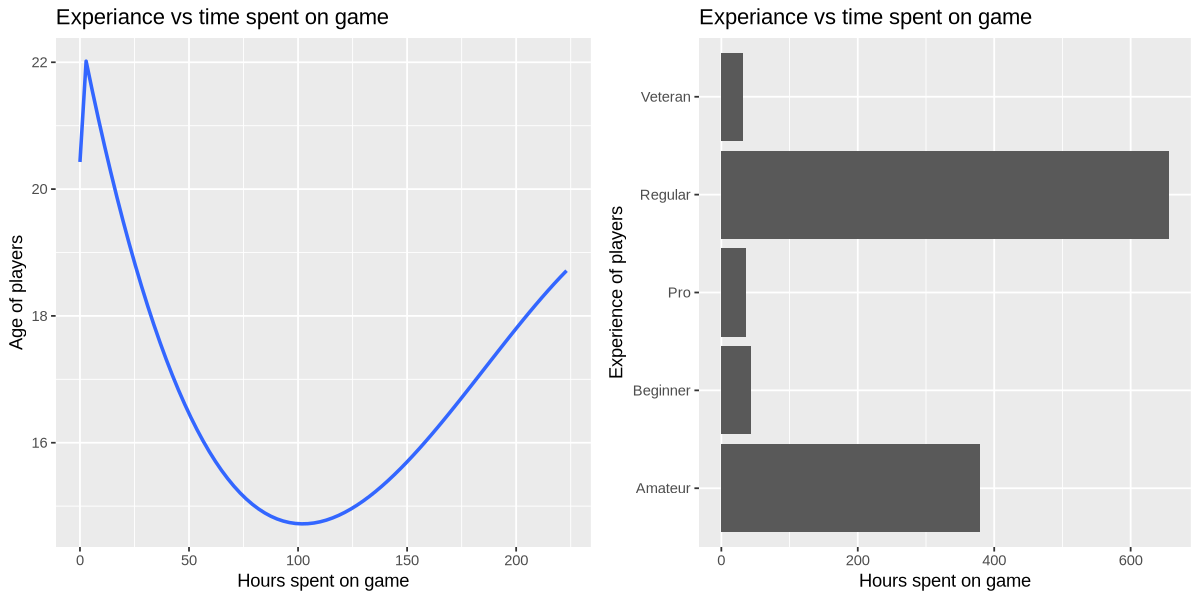

In [4]:
options(repr.plot.width=10, repr.plot.height=5)
players_plot_experience<-players_select|>
                         ggplot(aes(x=played_hours,y=experience))+
                         geom_bar(stat = "Identity")+
                         labs(x="Hours spent on game",y="Experience of players")+
                         ggtitle("Experiance vs time spent on game")
                         
                              

players_plot_Age<-players_select|>
                         ggplot(aes(x=played_hours,y=Age))+
                         geom_smooth(method = "auto", se = FALSE)+
                         labs(x="Hours spent on game",y="Age of players")+
                         ggtitle("Experiance vs time spent on game")
                              
plot_grid(players_plot_Age,players_plot_experience,ncol=2)

Now, the data set players_select is being represented in 2 plots that shows Age or experience versus the number of hours played. The purpose of these plots is to represent both the predictors and how it relates to played_hours for the original data frame. Age vs. played_hours is visualized using a smooth plot, that shows a concave up parabola slope, where the hours spent playing the game increases as age decreases until 100 hours, when it begins increasing with age. Experience is represented in a bar plot, indicating that regular and amateur players spend the most time playing.

In [5]:
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |>
    set_mode("regression") 

players_recipe <- recipe(played_hours ~ Age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

players_vfold <- vfold_cv(players_training, v = 5, strata = played_hours)

players_workflow <- workflow() |> 
    add_recipe(players_recipe) |> 
    add_model(players_spec)
players_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In this step, a specification is created, which essentially sets the engine and mode used for analyzing the dataset. By using "kknn", this indicates a package that would find the k-nearest neighbors, and the "regression" indicates that the model is being used to predict a certain outcome. Moreover, as the tune() function is used, this indicates that the number of neighbors best suited for this model will be determined later in the model.

Next, a recipe a used to assign the predictors for the played_hours, which are experience and Age. step_scale is an important step to scale all the values so that they influence the calculations using the same scope so that the impacts are relative to each predictor as opposed to each predictor's inidividual scope. This way, neither predictor has a substantial impact over the other, skewing the values. Finally, step_center ensures that all the predictors are at the center.

The players_vfold code is used to create a "nested" cross-validation object, which selects a model and estimates how well it generalizes to an unseen dataset to provide the most accurate results. Finally, by creating a workflow for the dataset, the model is specified and the pre-processing recipe steps are added.

In [20]:
gridvals <- tibble(neighbors = seq(from = 1, to = 100, by = 10))

players_results <- workflow() |> 
    add_recipe(players_recipe) |> 
    add_model(players_spec) |>
    tune_grid(object = players_workflow, resamples = players_vfold, grid = gridvals) |>
    collect_metrics()
players_results

players_min <- players_results |>
    arrange(std_err)|>
    filter(.metric == "rmse")|>
    slice(1)
players_min

Warning message:
“The `...` are not used in this function but one or more objects were passed: ''”
→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 27 rows.
               ✖ Assigned data has 28 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 28 to size 27.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,19.941093322,4,7.1292975,Preprocessor1_Model01
1,rsq,standard,0.002101013,4,0.0008415,Preprocessor1_Model01
11,rmse,standard,20.922420073,4,6.9253390,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
81,rsq,standard,0.01756003,4,0.006848334,Preprocessor1_Model09
91,rmse,standard,19.62666488,4,6.786866577,Preprocessor1_Model10
91,rsq,standard,0.15508569,4,0.143375528,Preprocessor1_Model10


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
61,rmse,standard,20.57443,4,6.400377,Preprocessor1_Model07


In this step, the best model configuration is selected using the tune_grid() function. The tune_grid() sets a parameter using grid, and with the cross-validation code and workflow, determines the best model confirguration based on different metrics (rmse and rsq) for different neighbors set by the "gridvals" code.

Next, the "players_min" code is used to find the lowest standard error in the dataset, and then see which number of K (neighbors) is associated with it, then using it for our players_testing dataset to do the final prediction. The code ensures that the table goes in ascending order of std_err, so by slicing the first row, you will get the smallest std_err and neighbor number. The code shows that the lowest standard error is 6.4 and the neighbors at 61. 

In [21]:
k_min <- players_min |>
          pull(neighbors)

players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 61) |>
          set_engine("kknn") |>
          set_mode("regression")

players_best_fit <- workflow() |>
          add_recipe(players_recipe) |>
          add_model(players_best_spec) |>
          fit(data = players_training)
players_best_fit

players_summary <- players_best_fit |>
           predict(players_testing) |>
           bind_cols(players_testing) |>
           metrics(truth = played_hours, estimate = .pred)|>
           filter(.metric=="rmse")
players_summary

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(61,     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 9.591984
Minimal mean squared error: 733.6491
Best kernel: rectangular
Best k: 61

ERROR: [1m[33mError[39m in `bind_cols()`:[22m
[33m![39m Can't recycle `..1` (size 49) to match `..2` (size 50).


In [25]:

players_pred <- predict(players_best_fit, players_training) |>
   


ERROR: Error in parse(text = x, srcfile = src): <text>:5:0: unexpected end of input
3:    
4: 
  ^


In [26]:
marathon_plot <- players_preds |>
    ggplot(aes(x = played_hours, y = experience)) +
    geom_point() +
    geom_line(mapping = aes(x = played_hours, y = .pred), color = "blue") +
    labs(x = "Maximum Distance", y = "Time Taken (hrs)", title = "Time Taken to Run Distance per Week ")
marathon_plot

ERROR: Error in eval(expr, envir, enclos): object 'players_preds' not found


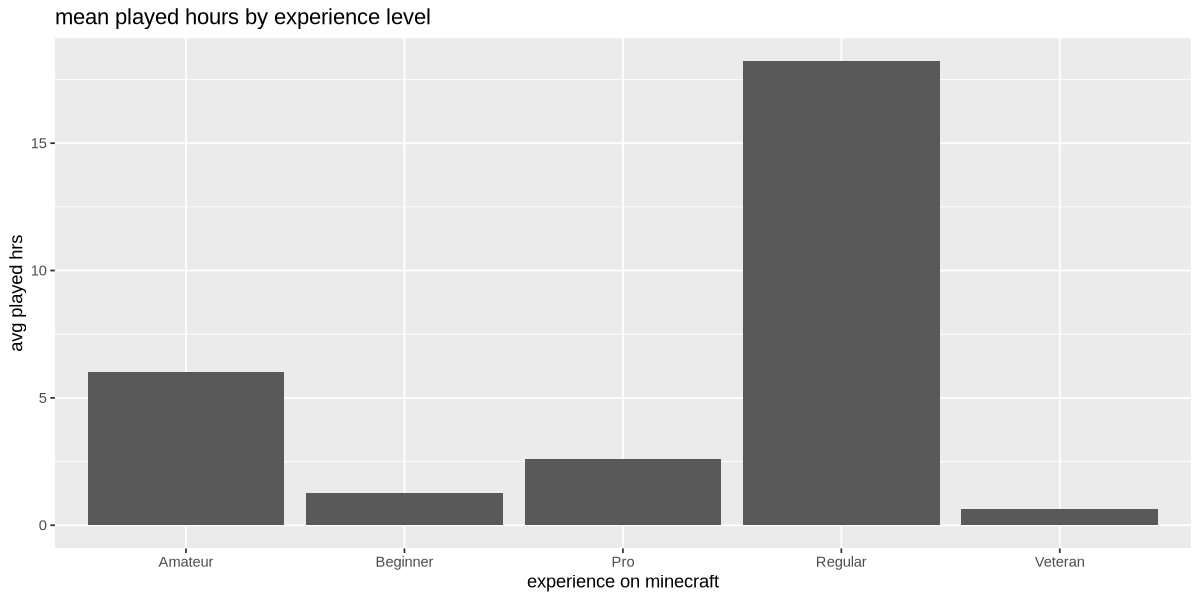

In [10]:
played_hrs_mean_experience <- players |>
    select(experience, played_hours) |>
    group_by(experience) |>
    summarize(avg_played_hrs_experience = mean(played_hours))

played_hrs_mean_experience_plot <- played_hrs_mean_experience |>
    ggplot(aes(x = experience, y = avg_played_hrs_experience)) + 
           geom_bar(stat = "identity" ) + 
           labs(x = "experience on minecraft", y = "avg played hrs", title = "mean played hours by experience level")
played_hrs_mean_experience_plot

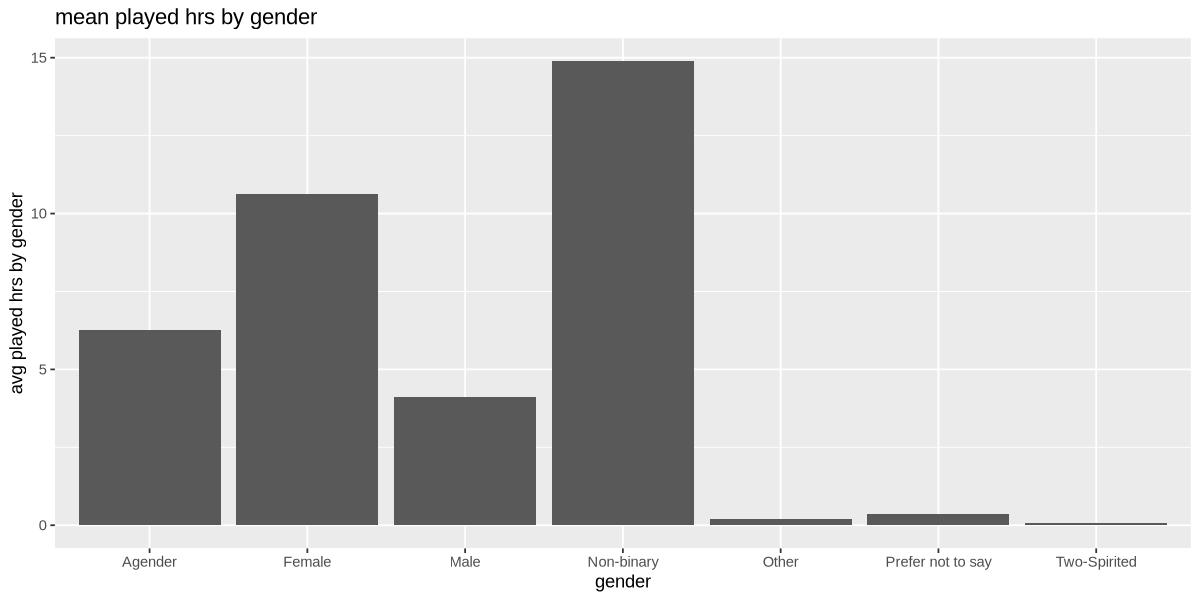

In [11]:
played_hrs_mean_gender <- players |>
    select(gender, played_hours) |>
    group_by(gender) |>
    summarize(avg_played_hrs_gender = mean(played_hours))

played_hrs_mean_gender_plot <- played_hrs_mean_gender |>
    ggplot(aes(x = gender, y = avg_played_hrs_gender)) + 
           geom_bar(stat = "identity") +
           labs(x = "gender", y = "avg played hrs by gender", title = "mean played hrs by gender")
played_hrs_mean_gender_plot

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_line()`).”


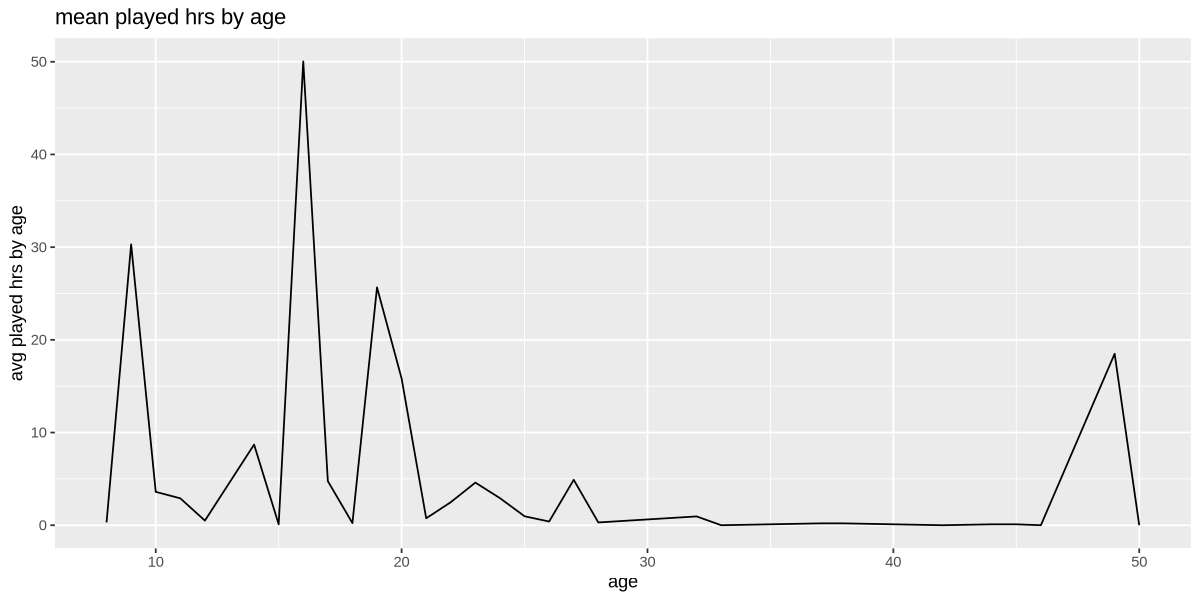

In [15]:
played_hrs_mean_age <- players |>
    select(Age, played_hours) |>
    group_by(Age) |>
    summarize(avg_played_hrs_age = mean(played_hours))

played_hrs_mean_age_plot <- played_hrs_mean_age |>
    ggplot(aes(x = Age, y = avg_played_hrs_age)) + 
           geom_line() +
           labs(x = "age", y = "avg played hrs by age", title = "mean played hrs by age")
played_hrs_mean_age_plot

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


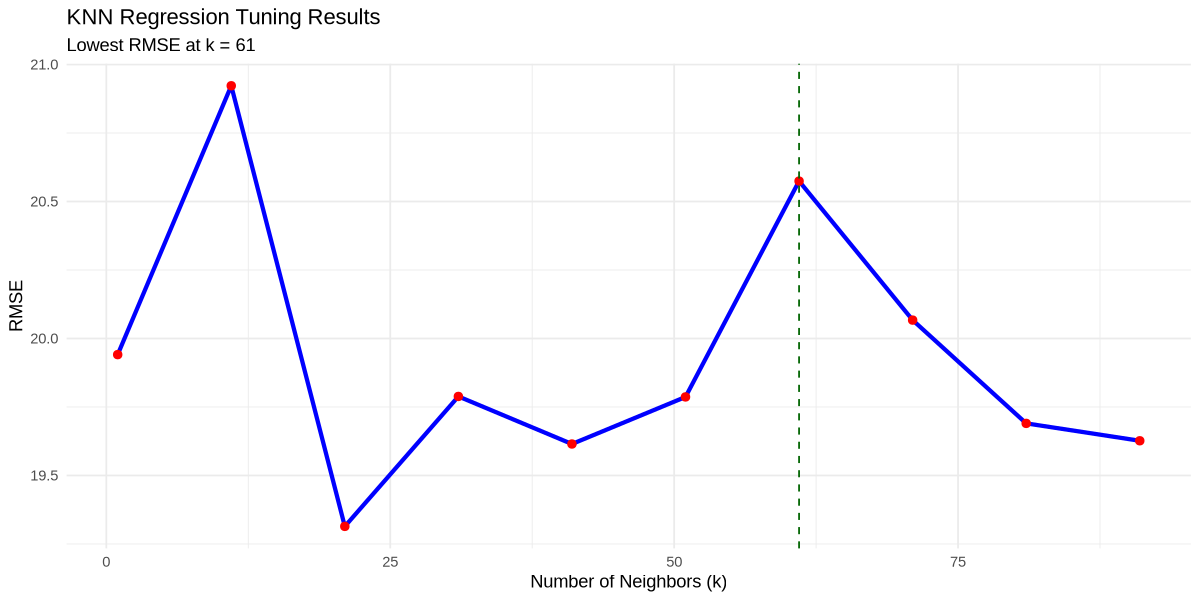

In [27]:
players_results |>
  filter(.metric == "rmse") |>
  ggplot(aes(x = neighbors, y = mean)) +
  geom_line(color = "blue", size = 1.2) +
  geom_point(size = 2, color = "red") +
  geom_vline(xintercept = k_min, linetype = "dashed", color = "darkgreen") +
  labs(title = "KNN Regression Tuning Results",
       x = "Number of Neighbors (k)",
       y = "RMSE",
       subtitle = paste("Lowest RMSE at k =", k_min)) +
  theme_minimal()